# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections [FACEMESH_TESSELATION]
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)) 

# Test MediaPipe Function with real camera 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# Directory path containing the videos
videos_path = '/GitHub/TSL_Recognition/TSL10/Videos_for_Test/Combine/Combine 1'

# Get all files in the directory
file_list = os.listdir(videos_path)

# Filter video files
video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

# Iterate over video files
for video_file in video_files:
    # Construct the full path to the video file
    video_path = os.path.join(videos_path, video_file)

    # Initialize VideoCapture object
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # Convert the frame to RGB format
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Detect actions
            results = holistic.process(frame_rgb)

            # Draw landmarks and actions on the frame
            draw_styled_landmarks(image, results)

            # Display the resulting frame
            cv2.imshow('Video', image)

            # Press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Release the video capture
cap.release()

# Close windows
cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [ ]:
# DATA_PATH = os.path.join('/GitHub/TSL_Recognition/TSL10/Extracted_Keypoints')
# actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
#                     'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
# no_sequences_train = 100
# sequence_length = 30

In [6]:
DATA_PATH_TRAIN = os.path.join('/GitHub/TSL_Recognition/TSL10/90_10/Train_Data')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_train = 90
sequence_length = 30

In [7]:
DATA_PATH_TEST = os.path.join('/GitHub/TSL_Recognition/TSL10/90_10/Test_Data')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_test = 10
sequence_length = 30

In [ ]:
# for sequence in range(100):
#     for action in actions: 
#         for sequence in range(no_sequences):
#             try: 
#                 os.makedirs(os.path.join(DATA_PATH, action))
#             except:
#                 pass

In [ ]:
# Set the path to the directory containing the videos
videos_dir = '/GitHub/TSL_Recognition/TSL10/All_Videos/'

keep_ex = '/GitHub/TSL_Recognition/TSL10/Extracted_Keypoints/'
# Set mediapipe model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through each folder
    for folder_name in os.listdir(videos_dir):
        folder_path = os.path.join(videos_dir, folder_name)

        # Check if it is a directory
        if not os.path.isdir(folder_path):
            continue

        # Get a list of all video files in the folder
        video_files = [f for f in os.listdir(folder_path)]

        # Loop through each video file
        for video_file in video_files:
            # Construct the full path to the video file
            video_path = os.path.join(folder_path, video_file)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Remove the file extension from the video file name
            video_file_name = os.path.splitext(video_file)[0]

            # Create a folder to save keypoints for each video
            keypoints_dir = os.path.join(keep_ex, folder_name, video_file_name)
            os.makedirs(keypoints_dir, exist_ok=True)

            # Loop through frames in the video
            frame_num = 0
            while cap.isOpened():
                # Read feed
                ret, frame = cap.read()

                if not ret:
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(keypoints_dir, str(frame_num))
                np.save(npy_path, keypoints)

                frame_num += 1
                if frame_num > 29:
                    break

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()

# Prepare Data for train and test

In [8]:
label_map = {label: num for num, label in enumerate(actions)}

sequences_train, labels_train = [], []
sequences_test, labels_test = [], []

def load_sequences(data_path, action, num_sequences):
    sequences = []
    labels = []
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    return sequences, labels


In [9]:
#TRAIN_DATA
for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TRAIN, action, no_sequences_train)
    sequences_train.extend(seq)
    labels_train.extend(lbl)

In [10]:
#TEST_DATA
for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TEST, action, no_sequences_test)
    sequences_test.extend(seq)
    labels_test.extend(lbl)

In [ ]:
# X = np.array(sequences_train)
# y = to_categorical(labels_train).astype(int)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train = np.array(sequences_train)
y_train = to_categorical(labels_train).astype(int)
X_test = np.array(sequences_test)
y_test = to_categorical(labels_test).astype(int)

In [12]:
X_train.shape

(900, 30, 1662)

# Train model

Train LSTM Model

In [ ]:
# model_LSTM = Sequential([
#     LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
#     Dropout(0.3),
#     LSTM(128, return_sequences=True, activation='relu'),
#     Dropout(0.3),
#     LSTM(64, return_sequences=False, activation='relu'),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(actions.shape[0], activation='softmax')])

# model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=[
#                    'categorical_accuracy'])
# model_LSTM.fit(X_train, y_train, validation_data=(
#     X_test, y_test), epochs=500, batch_size=32)

In [22]:
# K-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

loss_scores = []
accuracy_scores = []
train_loss_scores = []
train_accuracy_scores = []

for train_index, test_index in skf.split(X_train, labels_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    model_LSTM = Sequential([
        LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
        Dropout(0.1),
        LSTM(128, return_sequences=True, activation='relu'),
        Dropout(0.1),
        LSTM(64, return_sequences=False, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(actions.shape[0], activation='softmax')
    ])

    model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model_LSTM.fit(X_train_fold, y_train_fold, epochs=500, batch_size=32)

    _, accuracy = model_LSTM.evaluate(X_test_fold, y_test_fold)
    accuracy_scores.append(accuracy)
    loss_scores.append(history.history['loss'])
    train_loss_scores.append(history.history['loss'])
    train_accuracy_scores.append(history.history['categorical_accuracy'])

Epoch 1/500
23/23 [==============================] - 7s 100ms/step - loss: 2.3188 - categorical_accuracy: 0.0889
Epoch 2/500
23/23 [==============================] - 2s 107ms/step - loss: 2.3031 - categorical_accuracy: 0.1000
Epoch 3/500
23/23 [==============================] - 2s 106ms/step - loss: 2.2989 - categorical_accuracy: 0.1153
Epoch 4/500
23/23 [==============================] - 2s 107ms/step - loss: 2.2845 - categorical_accuracy: 0.1181
Epoch 5/500
23/23 [==============================] - 3s 112ms/step - loss: 2.2722 - categorical_accuracy: 0.1153
Epoch 6/500
23/23 [==============================] - 2s 106ms/step - loss: 2.2010 - categorical_accuracy: 0.1389
Epoch 7/500
23/23 [==============================] - 3s 110ms/step - loss: 2.1821 - categorical_accuracy: 0.1542
Epoch 8/500
23/23 [==============================] - 2s 101ms/step - loss: 2.1452 - categorical_accuracy: 0.1611
Epoch 9/500
23/23 [==============================] - 2s 96ms/step - loss: 2.0761 - categorical_a

In [23]:
for fold, loss in enumerate(loss_scores):
    print(f"Loss for Fold {fold+1}: {loss[-1]}")

mean_loss = np.mean([loss[-1] for loss in loss_scores])
print("Mean loss:", mean_loss)

print("Accuracy scores for each fold:", accuracy_scores)
print("Mean accuracy:", np.mean(accuracy_scores))

Loss for Fold 1: 0.15194746851921082
Loss for Fold 2: 0.11630843579769135
Loss for Fold 3: 0.056271426379680634
Loss for Fold 4: 0.1528712511062622
Loss for Fold 5: 0.02608257159590721
Mean loss: 0.10069623067975045
Accuracy scores for each fold: [0.9388889074325562, 0.8777777552604675, 0.9444444179534912, 0.9277777671813965, 0.9277777671813965]
Mean accuracy: 0.9233333230018616


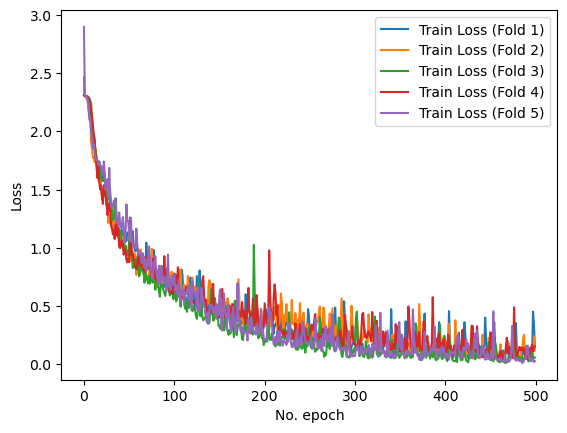

In [24]:
for fold, train_loss in enumerate(train_loss_scores):
    plt.plot(train_loss, label=f'Train Loss (Fold {fold+1})')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

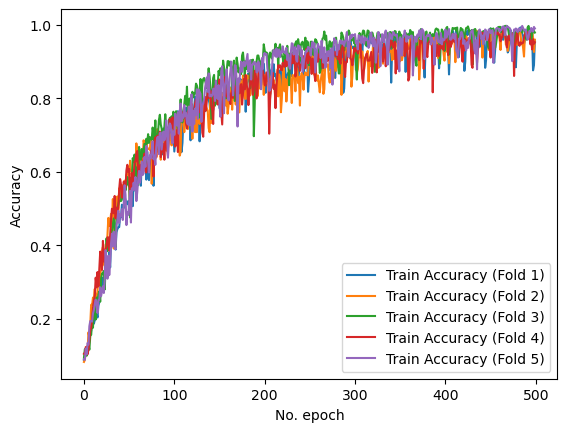

In [25]:
for fold, train_accuracy in enumerate(train_accuracy_scores):
    plt.plot(train_accuracy, label=f'Train Accuracy (Fold {fold+1})')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
model_LSTM.summary()

In [26]:
model_LSTM.save('../LSTM/90/LSTM_Model_90.h5')

In [27]:
model_LSTM = load_model('../LSTM/90/LSTM_Model_90.h5')

Test Accuracy Model

In [28]:
y_pred = model_LSTM.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

4/4 [==============================] - 1s 61ms/step


In [29]:
accuracies = []
for i, matrix in enumerate(confusion_matrices):
    tn, fp, fn, tp = matrix.ravel()
    label_accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracies.append(label_accuracy)
    print(f"Label {i + 1} accuracy: {label_accuracy}")

overall_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {overall_accuracy}")

Label 1 accuracy: 1.0
Label 2 accuracy: 0.98
Label 3 accuracy: 0.94
Label 4 accuracy: 0.96
Label 5 accuracy: 0.97
Label 6 accuracy: 1.0
Label 7 accuracy: 0.99
Label 8 accuracy: 1.0
Label 9 accuracy: 1.0
Label 10 accuracy: 0.98
Mean Accuracy: 0.982


# Test Model in real time

In [ ]:
# # 1. New detection variables
# sequence = []
# sentence = []
# predictions = []
# confidence = 0.8

# cap = cv2.VideoCapture(0)
# resolution = (800, 600)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])

# # Set mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)

#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # 2. Prediction logic
#         keypoints = extract_keypoints(results)
#         sequence.append(keypoints)
#         sequence = sequence[-30:]

#         if len(sequence) == 30:
#             res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
#             predictions.append(np.argmax(res))

#         # 3. Viz logic
#             if np.unique(predictions[-10:])[0] == np.argmax(res):
#                 if res[np.argmax(res)] >= confidence:

#                     if len(sentence) > 0:
#                         if actions[np.argmax(res)] != sentence[-1]:
#                             sentence.append(actions[np.argmax(res)])
#                     else:
#                         sentence.append(actions[np.argmax(res)])

#             if len(sentence) > 1:
#                 sentence = sentence[-1:]

#         cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
#         cv2.putText(image, ' '.join(sentence), (3, 30),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#         # Show to screen
#         cv2.imshow('Result', image)

#         # Break gracefully
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
        
#     cap.release()
#     cv2.destroyAllWindows()

Test With Video

In [ ]:
sequence = []
sentence = []
predictions = []
confidence = 0.5

videos_path = '/GitHub/TSL_Recognition/TSL10/For_Test/'
file_list = os.listdir(videos_path)
video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

for video_file in video_files:
    video_path = os.path.join(videos_path, video_file)
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                if np.unique(predictions[-15:])[0] == np.argmax(res):
                    if res[np.argmax(res)] >= confidence:

                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 1:
                    sentence = sentence[-1:]
            
            print(sentence)
            # cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
            # cv2.putText(image, ' '.join(sentence), (3, 30),
            # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # cv2.imshow('Video', image)

            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break

    cap.release()

cv2.destroyAllWindows()